In [14]:
####
# This notebook predicts housing prices in city of London using dataset provided by HM Land Registry 
# Objective is to build a baseline model and compare against open-source AutoML libraries
#
# Author : Harshal Patil
####

In [15]:
#import necessary modules
import numpy as np
import pandas as pd
import scipy as sc
import sklearn as skl
import matplotlib.pyplot as plt
import math as mth
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [16]:
#a tiny function to print top and bottom row from dataframe.
#good way to quickly inspect dataframe
def df2row(x,lines=1):
    return pd.concat([x.head(lines),x.tail(lines)])

In [17]:
###### LONDON HOUSING PRICE PREDICTION
# Data Location:
# https://data.gov.uk/dataset/4c9b7641-cf73-4fd9-869a-4bfeed6d440e/hm-land-registry-price-paid-data
#
# Data for 2018 Housing Transactions:
# http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018.csv

#!pwd
#Download file on Linux
!wget http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018.csv

#macOS    
#!curl -O http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018.csv


--2019-10-03 11:16:51--  http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018.csv
Resolving prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com (prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com)... 52.218.97.108
Connecting to prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com (prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com)|52.218.97.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://prod2.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018.csv [following]
--2019-10-03 11:16:51--  http://prod2.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018.csv
Resolving prod2.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com (prod2.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com)... 52.218.97.108
Reusing existing connection to prod.publicdata.landregistry.

In [18]:
# the heading definitions are at 
#https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd
#download the heading definitions as reference in this project

#!pwd
!wget https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd

#macOS
#!curl https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd > dataexplain.html

--2019-10-03 11:16:59--  https://www.gov.uk/guidance/about-the-price-paid-data
Resolving www.gov.uk (www.gov.uk)... 151.101.52.144, 2a04:4e42:d::144
Connecting to www.gov.uk (www.gov.uk)|151.101.52.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104656 (102K) [text/html]
Saving to: ‘about-the-price-paid-data.3’

about-the-price-pai 100%[===================>] 102.20K  --.-KB/s    in 0.01s   

2019-10-03 11:17:00 (6.95 MB/s) - ‘about-the-price-paid-data.3’ saved [104656/104656]



In [19]:
# check raw file lines - there is no heading present
#
!cat pp-2018.csv | head -n5

"{666758D7-43A9-3363-E053-6B04A8C0D74E}","405000","2018-01-25 00:00","WR15 8LH","D","N","F","RAMBLERS WAY","","","BORASTON","TENBURY WELLS","SHROPSHIRE","SHROPSHIRE","A","A"
"{666758D7-43AA-3363-E053-6B04A8C0D74E}","315000","2018-01-23 00:00","SY7 8QA","D","N","F","MONT CENISE","","","CLUN","CRAVEN ARMS","SHROPSHIRE","SHROPSHIRE","A","A"
"{666758D7-43AD-3363-E053-6B04A8C0D74E}","165000","2018-01-19 00:00","SY1 2BF","T","Y","F","42","","PENSON WAY","","SHREWSBURY","SHROPSHIRE","SHROPSHIRE","A","A"
"{666758D7-43B0-3363-E053-6B04A8C0D74E}","370000","2018-01-22 00:00","SY8 4DF","D","N","F","WILLOW HEY","","","ASHFORD CARBONEL","LUDLOW","SHROPSHIRE","SHROPSHIRE","A","A"
"{666758D7-43B3-3363-E053-6B04A8C0D74E}","320000","2018-01-19 00:00","TF10 7ET","D","N","F","3","","PRINCESS GARDENS","","NEWPORT","WREKIN","WREKIN","A","A"
cat: write error: Broken pipe


In [20]:
###### Exploratory Data Analysis (EDA)

In [21]:
#read dataset in memory
#assign column names as per data definition document provided (names are missing in csv)
#parse dates and set a datetimeindex in dataframe using it - to segment dataset by dates easily
file = "pp-2018.csv"
df = pd.read_csv(file,names=["id","price","date","postcode","type","new","lease","paon","saon",
                                         "street","locality","town","district","county","category","status"],
                parse_dates=["date"],index_col="date")

print("Dataset loaded in memory")
print("Dataset rows x columns",df.shape)

Dataset loaded in memory
Dataset rows x columns (1024432, 15)


In [22]:
#cut the memory requirement - filter the dataset immediately to only focus on London data
#city/town (i.e. the fieldname town) has "london" in it. 
#Adjust case to ensure all data picked up.
filter_london = df.town.apply(lambda x: "london" in x.lower())
df = df[filter_london]
#check top and bottom row in the dataframe
df2row(df)


,id,price,postcode,type,new,lease,paon,saon,street,locality,town,district,county,category,status
date,,,,,,,,,,,,,,,
2018-01-31,{666758D7-3BE8-3363-E053-6B04A8C0D74E},211500,SE20 8DN,F,N,L,55,NaN,ORCHARD GROVE,NaN,LONDON,BROMLEY,GREATER LONDON,A,A
2018-09-18,{80E1AA98-913C-7BF8-E053-6C04A8C00BF2},895000,SW19 8RR,S,N,F,1,NaN,SOUTH PARK ROAD,NaN,LONDON,MERTON,GREATER LONDON,A,A


In [23]:
#check data coverage across years and months
pd.crosstab(df.index.year, df.index.month,margins=True)

col_0,1,2,3,4,5,6,7,8,9,10,11,12,All
row_0,,,,,,,,,,,,,
2018,5059,4730,5575,4852,5228,6209,6156,6296,5607,5724,5818,5041,66295
All,5059,4730,5575,4852,5228,6209,6156,6296,5607,5724,5818,5041,66295


In [24]:
#do quick check on unique values counts in categorical fields
#there is good spread across values in type, new, lease 
df.loc[:,["type","new","lease","category","status"]].apply(pd.Series.value_counts)

,type,new,lease,category,status
A,NaN,NaN,NaN,51430.0,66295.0
B,NaN,NaN,NaN,14865.0,NaN
D,1035.0,NaN,NaN,NaN,NaN
F,42400.0,NaN,20387.0,NaN,NaN
L,NaN,NaN,45908.0,NaN,NaN
N,NaN,52847.0,NaN,NaN,NaN
O,5582.0,NaN,NaN,NaN,NaN
S,3699.0,NaN,NaN,NaN,NaN
T,13579.0,NaN,NaN,NaN,NaN
Y,NaN,13448.0,NaN,NaN,NaN


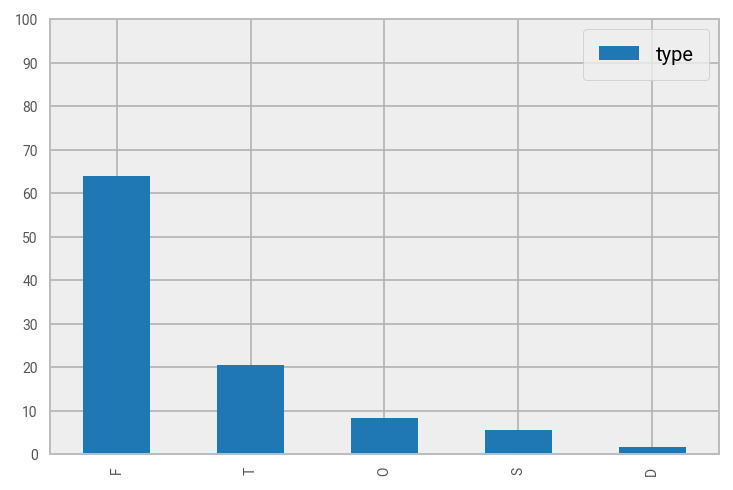

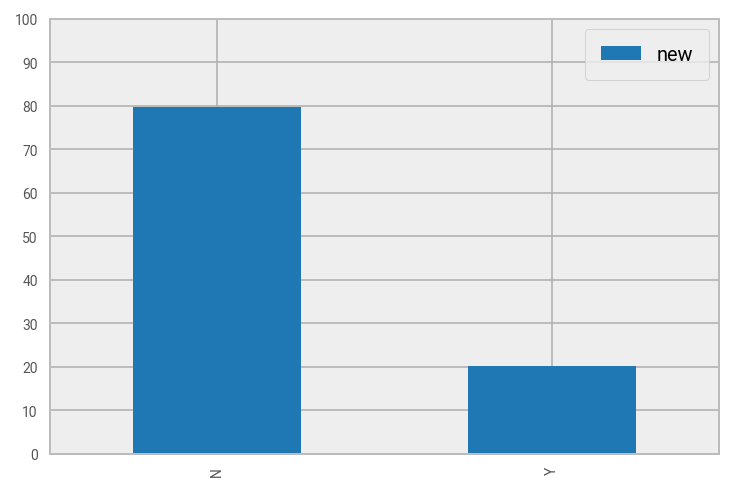

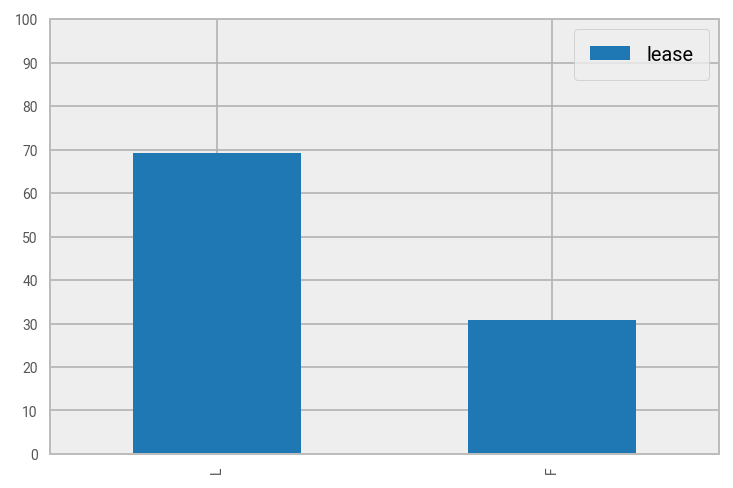

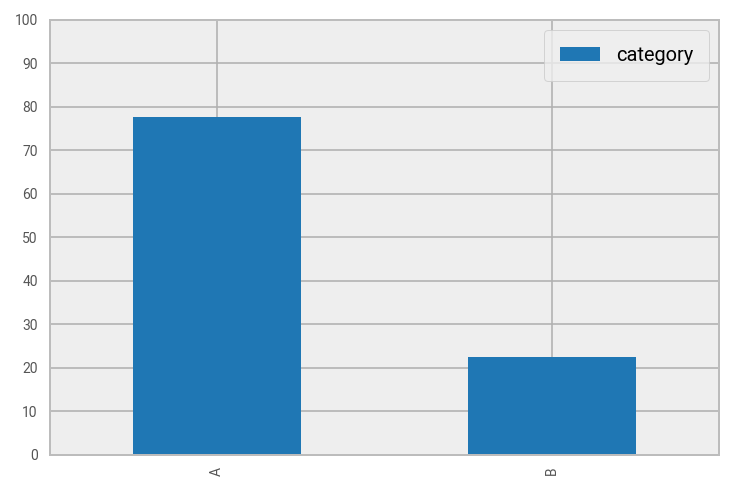

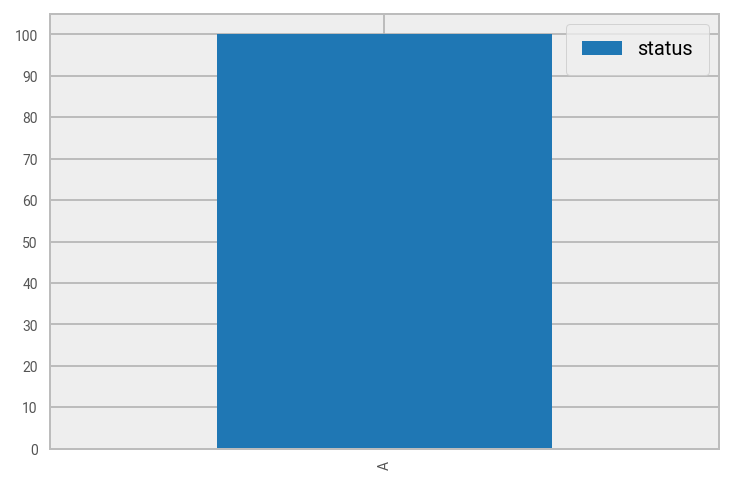

In [25]:
#check variation in the different categories to pick features that we can learn from
for f in ["type","new","lease","category","status"]:
    counts = df.loc[:,[f]].apply(pd.Series.value_counts)
    counts = (counts/counts.loc[:,f].sum())*100
    
    counts.plot(kind='bar',yticks=range(0,110,10))


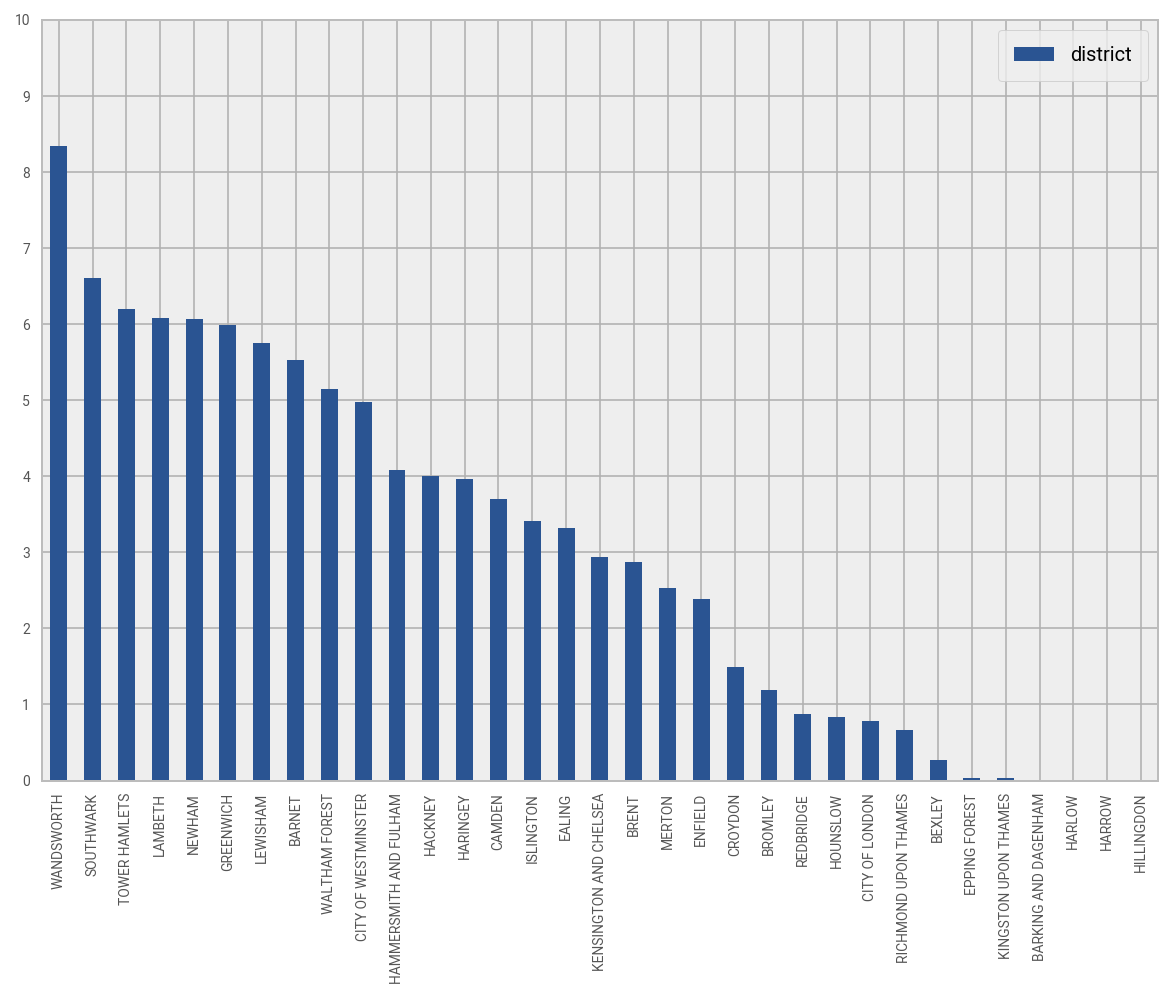

In [26]:
#check the spread in districts (london burroughs) as well
distcnt = df.district.value_counts()
distcnt = distcnt/distcnt.sum() * 100
distcnt.plot(kind='bar',yticks=range(0,11,1),color="#2a5492",figsize=(10,7),legend=True)    


In [27]:
#postcode is highly potent categorical feature to potentially capture lot of variation in home pricing - 
#however there are some data quality issues such as reallocation of postcodes which is not reflected back 
#into the current dataset
#this is one of the longer term model optimization path - currently just check how many unique values are there
df.postcode.unique().shape

(32158,)

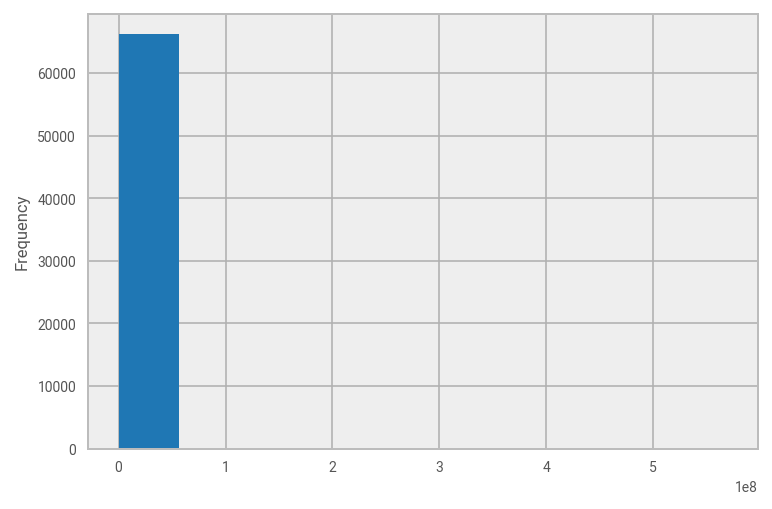

In [28]:
#check the dependent variable - home price - distribution
#convert to a make it normal - if necessary
#Histogram of price - skewed with long right tail
df.price.plot.hist()


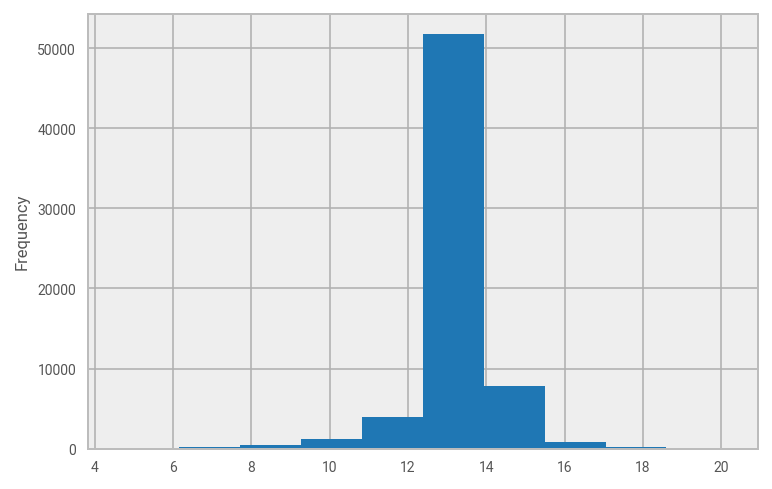

In [29]:
#Histogram shows a highly skewed distribution - which is expected for price. 
#Only handful would pay exceptionally high prices - while most will be in the lower bins paying average price.
#A log transformation will convert price into a closer to normal distribution. 
#This can then be modeled as dependent variable
#After making a forecast we undo log by passing thru exponential function

df["logprice"] = df.price.apply(mth.log)
df.logprice.plot.hist()


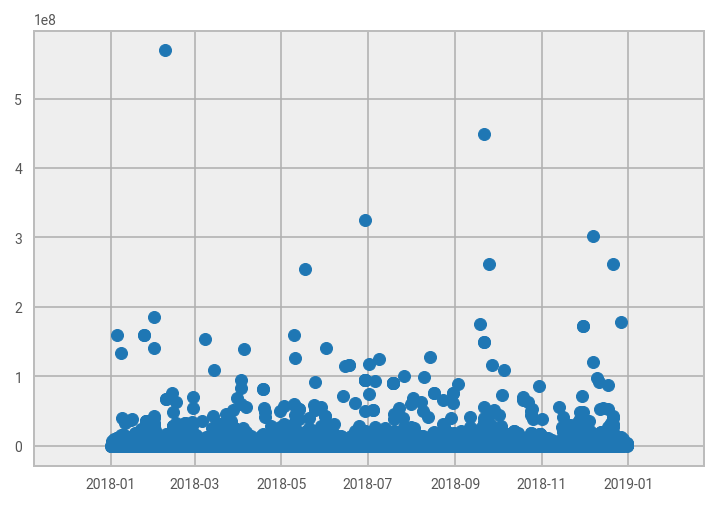

In [30]:
#visualize raw and log trend over years
plt.scatter(x=df.index,y=df.price)


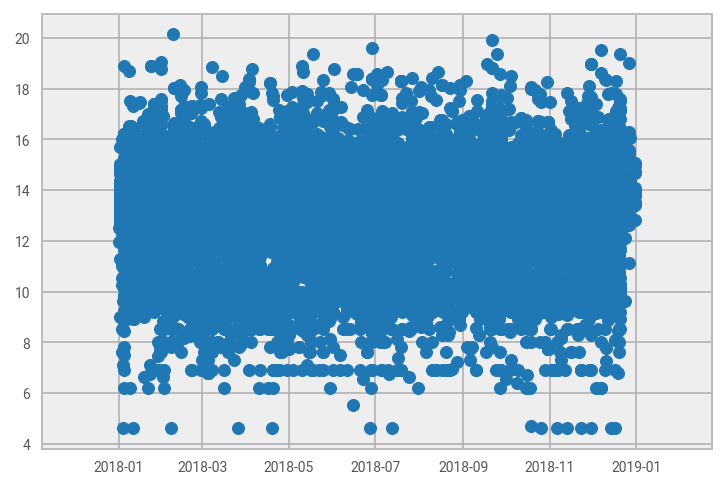

In [31]:
# Flat to slightly increasing trend over 2018
plt.scatter(x=df.index,y=df.logprice)



In [32]:
#nYear is a numeric feature that shows years since timeseries began. 
#Since each unit change in this feature is always equal to one year it is a numeric variable
#This representation allows to forecast into future time periods as well.
#df["year"] = df.index.year
df["nyear"] = df.index.year - 2018
df["quarter"] = df.index.quarter
df2row(df)

,id,price,postcode,type,new,lease,paon,saon,street,locality,town,district,county,category,status,logprice,nyear,quarter
date,,,,,,,,,,,,,,,,,,
2018-01-31,{666758D7-3BE8-3363-E053-6B04A8C0D74E},211500,SE20 8DN,F,N,L,55,NaN,ORCHARD GROVE,NaN,LONDON,BROMLEY,GREATER LONDON,A,A,12.261980,0,1
2018-09-18,{80E1AA98-913C-7BF8-E053-6C04A8C00BF2},895000,SW19 8RR,S,N,F,1,NaN,SOUTH PARK ROAD,NaN,LONDON,MERTON,GREATER LONDON,A,A,13.704579,0,3


In [33]:
#drop fields that are not candidates for independent variables/features such as address details that are too granular.
#also drop the regular price and keep logprice instead
#do it inplace to better manage memory
df.drop(columns=["id","price","postcode","paon","saon","street","locality","town","county","status"],inplace=True)
df2row(df)

,type,new,lease,district,category,logprice,nyear,quarter
date,,,,,,,,
2018-01-31,F,N,L,BROMLEY,A,12.261980,0,1
2018-09-18,S,N,F,MERTON,A,13.704579,0,3


In [34]:
# FEATURE SELECTION - BUILD UNIVARIATE MODELS AND PICK THE BEST FIT VARIABLES.

candidatefeatures = ["nyear","quarter","type","new","lease","district"]
candidatefcategorical = [False, True, True, True, True, True]
dependentfeature = "logprice"

#for categorical variables - dummay coding ie dummy variables will be generated for each feature to test out.
#lists to store coeff and perf measurements for models by individual candidate features
featurecount = 0

coeff = []
mse = []
r2 = []
rankorder = []
rankorderp = []

# Build univariate models to identify most promising features.
# Use the 3 most promising features to get the base model

for feature, iscategorical in zip(candidatefeatures, candidatefcategorical):

    Xlist = []
    ylist = []

    dset = df
    
    X = dset.loc[:,feature]
    y = dset.logprice
    
    # internal stuff - handle weird behaviors of packages
    X = pd.DataFrame({feature:X}) #series to dataframe
    y = pd.DataFrame({dependentfeature:y})
    
    if iscategorical:
        X = X[feature].apply(str) #so dummies will work always
        # convert categorical feature into dummy coding and have k-1 categories as reqd for modeling.
        X = pd.get_dummies(X,prefix=feature,drop_first=True)
   
    #train
    Xlist.append(X.iloc[dset.index.month<10,:])
    ylist.append(y.iloc[dset.index.month<10,:])
    
    #test
    Xlist.append(X.iloc[dset.index.month>9,:])
    ylist.append(y.iloc[dset.index.month>9,:])

    
    #instantiate and train a liner regression to estimate logprice
    model=LinearRegression()
    model.fit(Xlist[0],ylist[0])
    ypred = model.predict(Xlist[1])

    coeff.append(model.coef_)
    mse.append(mean_squared_error(ylist[1], ypred))
    r2.append(r2_score(ylist[1], ypred))


featureseldf = pd.DataFrame([candidatefcategorical,r2,mse,rankorder,rankorderp],columns=candidatefeatures,
                            index=["IsCategorical","R2","MSE","RankOrder","RankOrderp"])
print(featureseldf)


                     nyear      quarter       type         new     lease  \
IsCategorical        False         True       True        True      True   
R2            -9.15742e-08 -2.25119e-06  0.0921691  0.00252446   0.03674   
MSE               0.933066     0.933068   0.847066    0.930711  0.898785   
RankOrder             None         None       None        None      None   
RankOrderp            None         None       None        None      None   

                district  
IsCategorical       True  
R2             0.0775405  
MSE             0.860716  
RankOrder           None  
RankOrderp          None  


In [35]:
# fit model to Type, district, Lease (Freehold/Leasehold), New/Old property
# annual trend not applicable since training data has 1 year
# quarterly seasonality is not useful in improving R2 or reducing MSE

dset = pd.get_dummies(dset,
                      prefix=["type","new","lease","district"],
                      columns =  ["type","new","lease","district"], 
                      drop_first=True)
dset.drop(columns=["category","nyear","quarter"],
         inplace=True)

X_train = dset[dset.index.month < 10].drop(columns=["logprice"])
y_train = dset[dset.index.month < 10].logprice

X_test = dset[dset.index.month > 9].drop(columns=["logprice"])
y_test = dset[dset.index.month > 9].logprice

#instantiate and train a liner regression to estimate logprice
model=LinearRegression()
model.fit(X_train,y_train)
ypred = model.predict(X_test)

print(mean_squared_error(y_test, ypred))
print(r2_score(y_test, ypred))
print(X_train.columns)
print(model.coef_)


0.6970587104509249
0.25293767191094085
Index(['type_F', 'type_O', 'type_S', 'type_T', 'new_Y', 'lease_L',
       'district_BARNET', 'district_BEXLEY', 'district_BRENT',
       'district_BROMLEY', 'district_CAMDEN', 'district_CITY OF LONDON',
       'district_CITY OF WESTMINSTER', 'district_CROYDON', 'district_EALING',
       'district_ENFIELD', 'district_EPPING FOREST', 'district_GREENWICH',
       'district_HACKNEY', 'district_HAMMERSMITH AND FULHAM',
       'district_HARINGEY', 'district_HARLOW', 'district_HARROW',
       'district_HILLINGDON', 'district_HOUNSLOW', 'district_ISLINGTON',
       'district_KENSINGTON AND CHELSEA', 'district_KINGSTON UPON THAMES',
       'district_LAMBETH', 'district_LEWISHAM', 'district_MERTON',
       'district_NEWHAM', 'district_REDBRIDGE',
       'district_RICHMOND UPON THAMES', 'district_SOUTHWARK',
       'district_TOWER HAMLETS', 'district_WALTHAM FOREST',
       'district_WANDSWORTH'],
      dtype='object')
[-0.43776551 -1.56803556 -0.47420268 -0

In [36]:
df2row(df)

,type,new,lease,district,category,logprice,nyear,quarter
date,,,,,,,,
2018-01-31,F,N,L,BROMLEY,A,12.261980,0,1
2018-09-18,S,N,F,MERTON,A,13.704579,0,3


In [37]:
df.dtypes

type         object
new          object
lease        object
district     object
category     object
logprice    float64
nyear         int64
quarter       int64
dtype: object

In [38]:
####AUTOML TPOT
# convert categorical feature into dummy coding and have k-1 categories as reqd for modeling.
# prefer this one-hot encoding vs encoding each to a value
#X = pd.get_dummies(df,drop_first=True)
#df2row(X)
X = df
df2row(X)

,type,new,lease,district,category,logprice,nyear,quarter
date,,,,,,,,
2018-01-31,F,N,L,BROMLEY,A,12.261980,0,1
2018-09-18,S,N,F,MERTON,A,13.704579,0,3


In [39]:
import sklearn.preprocessing as sklp
features = X.columns
ftype = X.dtypes
prefix = "enc_"
for f,t in zip(features,ftype):
    if(t=="object"):
        encoder = sklp.LabelEncoder()
        newf = prefix + f
        X[newf] = encoder.fit_transform(X.loc[:,f])
        

In [40]:
df2row(X)

,type,new,lease,district,category,logprice,nyear,quarter,enc_type,enc_new,enc_lease,enc_district,enc_category
date,,,,,,,,,,,,,
2018-01-31,F,N,L,BROMLEY,A,12.261980,0,1,1,0,1,4,0
2018-09-18,S,N,F,MERTON,A,13.704579,0,3,3,0,0,25,0


In [41]:
#drop the character coded fields
X = X.loc[:,X.columns[X.dtypes != "object"]]
df2row(X)

,logprice,nyear,quarter,enc_type,enc_new,enc_lease,enc_district,enc_category
date,,,,,,,,
2018-01-31,12.261980,0,1,1,0,1,4,0
2018-09-18,13.704579,0,3,3,0,0,25,0


In [42]:
#timeseries so carve out manually
X_train = X[X.index.month < 10].drop(columns=["logprice"])
y_train = X[X.index.month < 10].logprice

X_test = X[X.index.month > 9].drop(columns=["logprice"])
y_test = X[X.index.month > 9].logprice


In [43]:
df2row(X_train)

,nyear,quarter,enc_type,enc_new,enc_lease,enc_district,enc_category
date,,,,,,,
2018-01-31,0,1,1,0,1,4,0
2018-09-18,0,3,3,0,0,25,0


In [44]:
import time
opfname = "tpot_automl_pipeline" + str(time.time()).replace(".","_") + ".py"
print (opfname)

tpot_automl_pipeline1570101432_4919186.py


In [47]:
import tpot

start=time.time()
tpotm = tpot.TPOTRegressor(generations=5, population_size=100, verbosity=2,
                          scoring='r2')
tpotm.fit(X_train, y_train)
print(tpotm.score(X_test, y_test))
tpotm.export(opfname)
end=time.time()

print (end - start)


Generation 1 - Current best internal CV score: 0.30011798615632557
Generation 2 - Current best internal CV score: 0.3014977965927003
Generation 3 - Current best internal CV score: 0.303722433480115
Generation 4 - Current best internal CV score: 0.3063635250545699
Generation 5 - Current best internal CV score: 0.3063635250545699

Best pipeline: RandomForestRegressor(GradientBoostingRegressor(input_matrix, alpha=0.75, learning_rate=0.01, loss=ls, max_depth=7, max_features=0.9000000000000001, min_samples_leaf=19, min_samples_split=2, n_estimators=100, subsample=0.45), bootstrap=True, max_features=0.5, min_samples_leaf=12, min_samples_split=18, n_estimators=100)
0.2675677523303187
9041.616294384003


In [48]:
#Auto Scikit Learn
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip3 install

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   194  100   194    0     0    729      0 --:--:-- --:--:-- --:--:--   729
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 163kB 1.7MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 440kB 1.7MB/s eta 0:00:01
  Created wheel for psutil: fil

In [49]:
!pip3 install auto-sklearn

     |████████████████████████████████| 3.4MB 1.7MB/s eta 0:00:01
     |████████████████████████████████| 4.9MB 18.3MB/s eta 0:00:01
     |████████████████████████████████| 142.8MB 94kB/s s eta 0:00:01    |████████████████▍               | 73.4MB 58.8MB/s eta 0:00:02     |█████████████████████████▍      | 113.5MB 58.8MB/s eta 0:00:01
     |████████████████████████████████| 296kB 50.1MB/s eta 0:00:01
  Created wheel for auto-sklearn: filename=auto_sklearn-0.5.2-cp36-cp36m-linux_x86_64.whl size=3716700 sha256=3a630f01b5c42f7f4adea83066fbdf78da68a6e4911d4a22c43e1fb224cec367
  Stored in directory: /home/cdsw/.cache/pip/wheels/67/21/43/182fed664b6474f88600c110c4ebd254d6256ba59175cef3fd
  Created wheel for pyrfr: filename=pyrfr-0.7.4-cp36-cp36m-linux_x86_64.whl size=2511842 sha256=cef84d452e1af1623f369244ec804fa92c27d6eddbbef997a6a01d66b0416fcd
  Stored in directory: /home/cdsw/.cache/pip/wheels/fb/98/fd/b1d53cab6d5ed836980777d9733d7e549d82a727650eed6f6d
Successfully built auto-sklearn pyrfr

In [56]:
df2row(X_train)

,nyear,quarter,enc_type,enc_new,enc_lease,enc_district,enc_category
date,,,,,,,
2018-01-31,0,1,1,0,1,4,0
2018-09-18,0,3,3,0,0,25,0


In [58]:
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import autosklearn.regression

feature_types = (['categorical'] * 7)

automl = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=3600,
        per_run_time_limit=360,
        tmp_folder='/tmp/autosklearn_regression_example_tmp',
        output_folder='/tmp/autosklearn_regression_example_out',
    )
automl.fit(X_train, y_train, dataset_name='london home',
               feat_type=feature_types)

print(automl.show_models())
predictions = automl.predict(X_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))


/home/cdsw/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-10-04 11:58:55,614:AutoMLSMBO(1)::london home] Could not find meta-data directory /home/cdsw/.local/lib/python3.6/site-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-10-04 11:58:55,616:EnsembleBuilder(1):london home] No models better than random - using Dummy Score!
[WARNING] [2019-10-04 11:58:55,623:EnsembleBuilder(1):london home] No models better than random - using Dummy Score!
[WARNING] [2019-10-04 11:58:57,628:EnsembleBuilder(1):london home] No models better than random - using Dummy Score!
[WARNING] [2019-10-04 11:58:59,632:EnsembleBuilder(1):london home] No models better than random - using Dummy Score!
[WARNING] [2019-10-04 11:59:01,637:EnsembleBuilder(1):london home] No models better than random - using Dummy Score!


/home/cdsw/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/cdsw/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/cdsw/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/cdsw/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/cdsw/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/cdsw/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evalu

1
['/tmp/autosklearn_regression_example_tmp/.auto-sklearn/ensembles/1.0000000000.ensemble', '/tmp/autosklearn_regression_example_tmp/.auto-sklearn/ensembles/1.0000000001.ensemble', '/tmp/autosklearn_regression_example_tmp/.auto-sklearn/ensembles/1.0000000002.ensemble', '/tmp/autosklearn_regression_example_tmp/.auto-sklearn/ensembles/1.0000000003.ensemble', '/tmp/autosklearn_regression_example_tmp/.auto-sklearn/ensembles/1.0000000004.ensemble', '/tmp/autosklearn_regression_example_tmp/.auto-sklearn/ensembles/1.0000000005.ensemble', '/tmp/autosklearn_regression_example_tmp/.auto-sklearn/ensembles/1.0000000006.ensemble', '/tmp/autosklearn_regression_example_tmp/.auto-sklearn/ensembles/1.0000000007.ensemble', '/tmp/autosklearn_regression_example_tmp/.auto-sklearn/ensembles/1.0000000008.ensemble', '/tmp/autosklearn_regression_example_tmp/.auto-sklearn/ensembles/1.0000000009.ensemble', '/tmp/autosklearn_regression_example_tmp/.auto-sklearn/ensembles/1.0000000010.ensemble', '/tmp/autosklearn_